In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline

- pd.merge()、df.join()、pd.concat()、df.append()
- df.reset_index()
- 原来的思路是先按时间排序，再按球队名称排序，2005-2006赛季数据没问题，但是没有检查其他赛季。事后使用的时候发现，其他赛季的有不同程度的错误。具体原因见下图

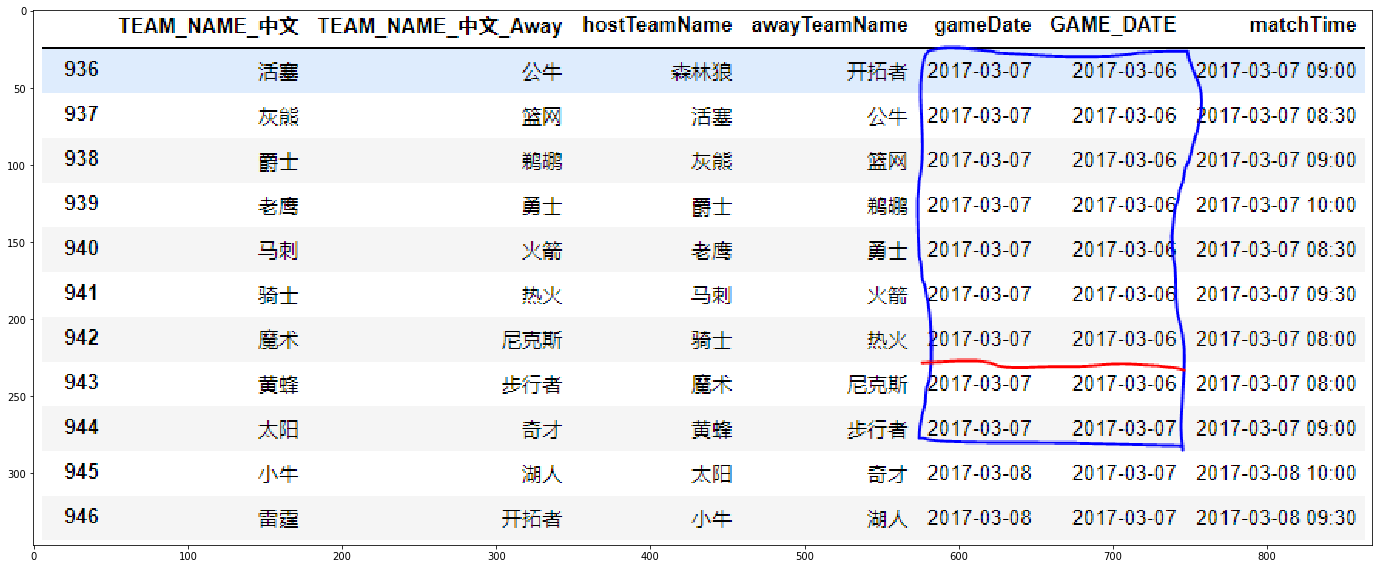

In [2]:
plt.imshow(plt.imread('error_example.PNG'))
plt.gcf().set_figwidth(24)
plt.gcf().set_figheight(32)

- 换一种思路，先按球队名称排序，再按时间排序。然后再添加‘总分’，‘大小分’，‘比赛双方’列
- 另外，发现2013-14赛季数据有误，多了9条，但是betId没有重复。排查办法:

- 紧跟着发现其他年份也有hostScore=0的情况，说明新浪爱彩的数据有一些小噪声，最后处理的标准：所有的数据都保证betId唯一，13-14年、16-17年还要确保hostScore值不为0，最后保证数据行数为1230或990。数据行数，betId唯一的行数，hostScore=0的行数，如下

In [13]:
year_dirs = ['../数据收集/'+f for f in os.listdir('../数据收集') if '.' not in f]
for year in year_dirs:
    df_lottery = pd.read_excel(year+'/lottery_results.xlsx')
    print(year,df_lottery.shape,df_lottery['betId'].unique().shape,(df_lottery[df_lottery['hostScore']==0]).shape)

../数据收集/2005-06 (1230, 27) (1230,) (0, 27)
../数据收集/2006-07 (1230, 27) (1230,) (0, 27)
../数据收集/2007-08 (1230, 27) (1230,) (0, 27)
../数据收集/2008-09 (1230, 27) (1230,) (0, 27)
../数据收集/2009-10 (1230, 27) (1230,) (0, 27)
../数据收集/2010-11 (1244, 27) (1230,) (0, 27)
../数据收集/2011-12 (990, 27) (990,) (0, 27)
../数据收集/2012-13 (1230, 27) (1230,) (1, 27)
../数据收集/2013-14 (1239, 27) (1239,) (9, 27)
../数据收集/2014-15 (1232, 27) (1230,) (0, 27)
../数据收集/2015-16 (1238, 27) (1230,) (0, 27)
../数据收集/2016-17 (1239, 27) (1231,) (1, 27)


- 经过一系列反复发现数据异常，说明一开始df.info()、df.describe()数据是有用的，但是还不够，对于数值型的数据列，也要做和object类型一样的唯一值、频率统计

In [4]:
#英文-中文球队名字典
def get_namedict():
    name_dict = {}
    with open('../数据收集/english_name-to-chinese_name.txt','r',encoding='utf-8') as f:
        for line in f.read().split('\n'):
            if line:
                e,c = line.split('-')
                name_dict[e]=c
    return name_dict

def merge_one_df(df):
    df_group = df.groupby('GAME_ID')
    df_result=pd.DataFrame()
#     columns = df.columns.append(df.columns.map(lambda x: 'Away_'+x))
    for game_id in df['GAME_ID'].unique():
        df_x_game = df_group.get_group(game_id)
        df_host = df_x_game[df_x_game['MATCHUP'].str.contains('vs.')]
        df_away = df_x_game[df_x_game['MATCHUP'].str.contains('@')]
        df_result = df_result.append(pd.merge(df_host,df_away,on=['GAME_ID','GAME_DATE','SEASON_ID','MIN','VIDEO_AVAILABLE'],suffixes=['','_Away']),ignore_index=True)
#     df_result.columns = columns
    return df_result

In [8]:
name_dict = get_namedict()
for year in year_dirs:
    print(year)
    df_nba = pd.read_excel(year+'/games.xlsx')
    df_lottery = pd.read_excel(year+'/lottery_results.xlsx')
    
    #添加中文球队名称，然后同一场比赛合并为一行
    df_nba['TEAM_NAME_中文'] = df_nba['TEAM_NAME'].map(lambda x:name_dict[x])
    df_nba = merge_one_df(df_nba)
    
    #处理2013-14赛季的错误数据
    if '2013-14' in year or '2016-17' in year:
        df_lottery.drop(df_lottery[df_lottery['hostScore']==0].index,inplace=True)
    
    #去掉重复项并增加以天为单位的比赛时间
    df_lottery = df_lottery.drop_duplicates('betId')
    df_lottery['gameDate'] = df_lottery['matchTime'].map(lambda x:x.split(' ')[0])
    
    #按照比赛时间-球队的顺序排序
    df_nba.sort_values(['TEAM_NAME_中文','GAME_DATE'],inplace = True)
    df_lottery.sort_values(['hostTeamName','gameDate'],inplace = True)
    
    #pd.concat()是按照index进行的拼接，在sort_values()之后两个df的index被打乱了
    #直接拼接会出现类似下一段代码的情况
    df_nba.reset_index(drop=True,inplace=True)
    df_lottery.reset_index(drop=True,inplace=True)
    
    
    #验证两个df是否完全对应
    is_corresponding = df_nba['TEAM_NAME_中文']==df_lottery['hostTeamName']
    if not is_corresponding.all():
        print('---error---')
        continue
    #拼接并保存（不保存index）
    df_result = pd.concat([df_nba,df_lottery],axis=1)
    df_result['总分'] = df_result['PTS']+df_result['PTS_Away']
    df_result['大小分'] = (df_result['总分']-df_result['jcTotalScore']).map(lambda x:'大' if x >0 else '小')
    df_result['比赛双方'] = df_result['TEAM_NAME_中文']+' vs. '+df_result['TEAM_NAME_中文_Away']
    df_result.to_excel(year.split('/')[-1]+'-records.xlsx',index=False)

../数据收集/2016-17


In [12]:
#验证下是否PTS和hostScore相等
for year in year_dirs:
    df = pd.read_excel(year.split('/')[-1]+'-records.xlsx')
    print(year,(df['PTS']==df['hostScore']).shape)

../数据收集/2005-06 (1230,)
../数据收集/2006-07 (1230,)
../数据收集/2007-08 (1230,)
../数据收集/2008-09 (1230,)
../数据收集/2009-10 (1230,)
../数据收集/2010-11 (1230,)
../数据收集/2011-12 (990,)
../数据收集/2012-13 (1230,)
../数据收集/2013-14 (1230,)
../数据收集/2014-15 (1230,)
../数据收集/2015-16 (1230,)
../数据收集/2016-17 (1230,)


下面的例子体会一下merge、join、concat的区别：<br\>
- concat()以index为依据拼接
- join()、merge()以on指定的列为依据拼接

In [14]:
a=pd.DataFrame({'a':[1,2],'b':[3,4]},index=[1,2])
b=pd.DataFrame({'f':[1,2],'g':[44,55]})
# a=a.reset_index(drop=True)
pd.concat([a,b],axis=1)

,a,b,f,g
0,NaN,NaN,1.0,44.0
1,1.0,3.0,2.0,55.0
2,2.0,4.0,NaN,NaN


In [15]:
pd.concat([a,b])

,a,b,f,g
1,1.0,3.0,NaN,NaN
2,2.0,4.0,NaN,NaN
0,NaN,NaN,1.0,44.0
1,NaN,NaN,2.0,55.0


In [16]:
pd.merge(a,b,left_on='a',right_on='f')

,a,b,f,g
0,1,3,1,44
1,2,4,2,55


In [17]:
a.join(b,how='outer')

,a,b,f,g
0,NaN,NaN,1.0,44.0
1,1.0,3.0,2.0,55.0
2,2.0,4.0,NaN,NaN
